Notebook that investigates what happens when we control for composite of two explanatory variables in a regression.

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
from statsmodels.stats.moment_helpers import cov2corr
import statsmodels.formula.api as sm_form
np.random.seed(5000)
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R 
library(dagitty)

In [3]:
def plot(df):
    fig = plt.figure(figsize=(8, 2))
    ax = fig.add_subplot(1, 2, 1)
    df.iloc[:5].plot(ax=ax)
    ax = fig.add_subplot(1, 2, 2)
    df.plot(ax=ax)
    return fig, ax

Simulate series for two explanatory variables `x1` and `x2`. Variable `x3` is a composite of `x1` and `x2`: $x3t = x1_t + x2_t$ for each $t$. This means change of 1 unit in either changes `y` to change by one unit.

drift.x1 :1.2
drift.x2 :1.1
L1.x1.x1 :0.6
L1.x2.x1 :0
L1.x1.x2 :0
L1.x2.x2 :0.8
sqrt.var.x1 :50
sqrt.cov.x1.x2 :34.64101615137755
sqrt.var.x2 :30


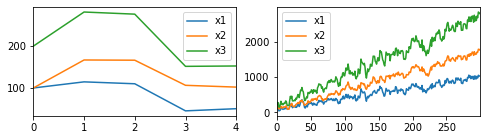

In [4]:
initial_state = [0, 0]
std_y1 = 50
std_y2 = 30
params = [1.2, 1.1, 0.6, 0, 0, 0.8, std_y1, np.sqrt(0.8*std_y1*std_y2), std_y2]

endog = pd.DataFrame({"x1":[np.nan, np.nan], "x2":[np.nan, np.nan]}, index=[0, 1])
mod = sm.tsa.VARMAX(endog, order=(1, 0), trend="t", trend_offset=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))

df = pd.DataFrame(mod.simulate(params=params, nsimulations=300, initial_state=initial_state))
for col in df.columns:
    df[col] = df[col] + 100
df["x3"] = df["x1"] + df["x2"] 

fig, ax = plot(df)

Dependent variable is such that changes in it are driven by changes in `x1` and `x2`, plus by an exogenus random process. One unit change in `x1` changes `y` by amount of `x1_change_effect` (and similarly for `y2`, amount `x2_change_effect`). 

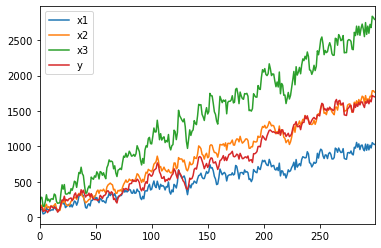

In [5]:
x1_change_effect = 0.1
x2_change_effect = 0.7

y_series = np.matmul(
    df[["x1", "x2"]].diff().values,
    np.expand_dims(np.array([x1_change_effect, x2_change_effect]), axis=1)
) 
y_series = y_series.flatten() + np.random.normal(loc=0.0, scale=25.0, size=len(y_series))

y_series[0] = 100
df["y"] = np.cumsum(y_series)

_ = df.plot()

When regressing $y \sim x1 + x2$, we recover correct estimates for `x1_change_effect` and `x2_change_effect`.

In [6]:
df_t = df.copy().diff().dropna()
ols_res = sm_form.ols(formula="y ~ x1 + x2", data=df_t).fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     324.9
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           2.18e-75
Time:                        14:29:19   Log-Likelihood:                -1389.1
No. Observations:                 299   AIC:                             2784.
Df Residuals:                     296   BIC:                             2795.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2345      1.476      0.836      0.4

Below we run regressions $y \sim x1 + x3$ and $y \sim x2 + x3$. In these estimates for `x3` are what we would expect: controlling for `x1` (`x2`) "distills" away the effect of `x1` (`x2`) from `x3`, and the estimate for `x3` is then same as for `x2` (`x1`) in above regression. Conversely, estimate for `x1` in below regression **are biased**! It amounts to

$$coef_{x1} - coef_{x2},$$

where $coef$ refers to estimated coefficient in above regression. Similarly, for `x2` we have below

$$coef_{x2} - coef_{x1}.$$

That is, in regression below, controlling for `x3` distorts the estimate for `x1` (`x2`) by the amount of $coef_{x2}$ ($coef_{x1}$).

In [7]:
df_t = df.copy().diff().dropna()
ols_res = sm_form.ols(formula="y ~ x1 + x3", data=df_t).fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     324.9
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           2.18e-75
Time:                        14:29:19   Log-Likelihood:                -1389.1
No. Observations:                 299   AIC:                             2784.
Df Residuals:                     296   BIC:                             2795.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2345      1.476      0.836      0.4

In [8]:
df_t = df.copy().diff().dropna()
ols_res = sm_form.ols(formula="y ~ x2 + x3", data=df_t).fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     324.9
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           2.18e-75
Time:                        14:29:19   Log-Likelihood:                -1389.1
No. Observations:                 299   AIC:                             2784.
Df Residuals:                     296   BIC:                             2795.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2345      1.476      0.836      0.4

Why does this happen? To aid understanding, here is a directed acyclic graph of true causal effects in the data generating process.

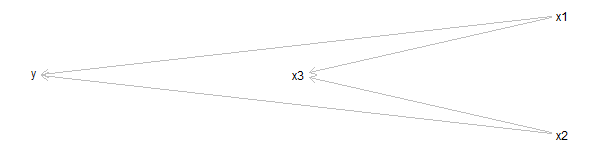

In [9]:
%%R -h 150 -w 600
g = dagitty('dag {
    x1 [exposure,pos="0.500,-1.000"]
    x2 [pos="0.500,1.000"]
    x3 [adjusted,pos="0.250,0.000"]
    y [outcome,pos="0.000,0.000"]
    x1 -> x3
    x1 -> y
    x2 -> x3
    x2 -> y
}')
plot(g)

Now imagine we are interested in estimate for effect of `x1` on `y`. In this case a simple regression $y \sim x1$ would suffice. However, is we instead run regression $y \sim x1 + x3$, this opens up a biasing path between `x1` and `y` via `x1 -> x3 <- x2 -> y` (shown in below plot). The amout of bias from path `x1 -> x3` amouts to -1, from path `x3 <- x2` to 1, and from path `x2 -> y` to $-coef(x2) = -0.6714$. That is, instead of $coef(x1)=0.1213$ we get as an estimate for `x1`

$$0.1213 -1 + 1 - 0.6714 = -0.5501.$$

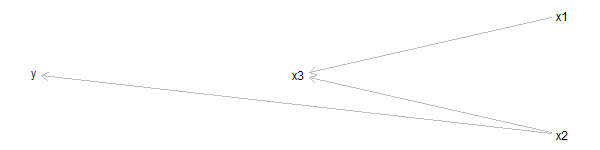

In [10]:
%%R -h 150 -w 600
plot(backDoorGraph(g))